# Exploratory Data Analysis 

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer
from datetime import datetime
import warnings

warnings.simplefilter(action='ignore', category=FutureWarning)
plt.rcParams['figure.figsize'] = (12, 5)

%load_ext autoreload
%autoreload 2

print(f"Timestamp: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")

Analysis timestamp: 2025-08-15 21:36:27


## Raw Data Analysis

Initial exploration of the raw dataset before preprocessing.

In [2]:
# Load raw data
df_raw = pd.read_csv('../data/raw/train.csv')

### Basic data info

In [3]:
print(f"Dataset shape: {df_raw.shape[0]:,} rows x {df_raw.shape[1]} columns")
print(f"Memory usage: {df_raw.memory_usage(deep=True).sum() / 1024**2:.1f} MB")

print(f"\nColumns: {list(df_raw.columns)}")

print(f"\nFirst 5 rows:")
df_raw.head()

Dataset shape: 1,804,874 rows x 45 columns
Memory usage: 1486.3 MB

Columns: ['id', 'target', 'comment_text', 'severe_toxicity', 'obscene', 'identity_attack', 'insult', 'threat', 'asian', 'atheist', 'bisexual', 'black', 'buddhist', 'christian', 'female', 'heterosexual', 'hindu', 'homosexual_gay_or_lesbian', 'intellectual_or_learning_disability', 'jewish', 'latino', 'male', 'muslim', 'other_disability', 'other_gender', 'other_race_or_ethnicity', 'other_religion', 'other_sexual_orientation', 'physical_disability', 'psychiatric_or_mental_illness', 'transgender', 'white', 'created_date', 'publication_id', 'parent_id', 'article_id', 'rating', 'funny', 'wow', 'sad', 'likes', 'disagree', 'sexual_explicit', 'identity_annotator_count', 'toxicity_annotator_count']

First 5 rows:


,id,target,comment_text,severe_toxicity,obscene,identity_attack,insult,threat,asian,atheist,...,article_id,rating,funny,wow,sad,likes,disagree,sexual_explicit,identity_annotator_count,toxicity_annotator_count
0,59848,0.000000,"This is so cool. It's like, 'would you want yo...",0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,...,2006,rejected,0,0,0,0,0,0.0,0,4
1,59849,0.000000,Thank you!! This would make my life a lot less...,0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,...,2006,rejected,0,0,0,0,0,0.0,0,4
2,59852,0.000000,This is such an urgent design problem; kudos t...,0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,...,2006,rejected,0,0,0,0,0,0.0,0,4
3,59855,0.000000,Is this something I'll be able to install on m...,0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,...,2006,rejected,0,0,0,0,0,0.0,0,4
4,59856,0.893617,haha you guys are a bunch of losers.,0.021277,0.0,0.021277,0.87234,0.0,0.0,0.0,...,2006,rejected,0,0,0,1,0,0.0,4,47


In [4]:
# Dataset information and statistics
print(df_raw.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1804874 entries, 0 to 1804873
Data columns (total 45 columns):
 #   Column                               Dtype  
---  ------                               -----  
 0   id                                   int64  
 1   target                               float64
 2   comment_text                         object 
 3   severe_toxicity                      float64
 4   obscene                              float64
 5   identity_attack                      float64
 6   insult                               float64
 7   threat                               float64
 8   asian                                float64
 9   atheist                              float64
 10  bisexual                             float64
 11  black                                float64
 12  buddhist                             float64
 13  christian                            float64
 14  female                               float64
 15  heterosexual                    

In [5]:
# Numerical columns summary
df_raw.describe().style.format('{:.2f}')

,id,target,severe_toxicity,obscene,identity_attack,insult,threat,asian,atheist,bisexual,black,buddhist,christian,female,heterosexual,hindu,homosexual_gay_or_lesbian,intellectual_or_learning_disability,jewish,latino,male,muslim,other_disability,other_gender,other_race_or_ethnicity,other_religion,other_sexual_orientation,physical_disability,psychiatric_or_mental_illness,transgender,white,publication_id,parent_id,article_id,funny,wow,sad,likes,disagree,sexual_explicit,identity_annotator_count,toxicity_annotator_count
count,1804874.00,1804874.00,1804874.00,1804874.00,1804874.00,1804874.00,1804874.00,405130.00,405130.00,405130.00,405130.00,405130.00,405130.00,405130.00,405130.00,405130.00,405130.00,405130.00,405130.00,405130.00,405130.00,405130.00,405130.00,405130.00,405130.00,405130.00,405130.00,405130.00,405130.00,405130.00,405130.00,1804874.00,1026228.00,1804874.00,1804874.00,1804874.00,1804874.00,1804874.00,1804874.00,1804874.00,1804874.00,1804874.00
mean,3738433.79,0.10,0.00,0.01,0.02,0.08,0.01,0.01,0.00,0.00,0.03,0.00,0.10,0.13,0.00,0.00,0.03,0.00,0.02,0.01,0.11,0.05,0.00,0.00,0.01,0.01,0.00,0.00,0.01,0.01,0.06,49.86,3722687.06,281359.71,0.28,0.04,0.11,2.45,0.58,0.01,1.44,8.78
std,2445186.76,0.20,0.02,0.06,0.08,0.18,0.05,0.09,0.05,0.03,0.17,0.03,0.26,0.31,0.05,0.03,0.14,0.02,0.12,0.06,0.27,0.20,0.01,0.01,0.04,0.04,0.02,0.02,0.09,0.07,0.22,27.70,2450261.21,103929.28,1.06,0.24,0.46,4.73,1.87,0.05,17.87,43.50
min,59848.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,2.00,61006.00,2006.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,3.00
25%,796975.25,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,21.00,796018.75,160120.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,4.00
50%,5223774.50,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,54.00,5222993.00,332126.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,4.00
75%,5769854.50,0.17,0.00,0.00,0.00,0.09,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,54.00,5775757.50,366237.00,0.00,0.00,0.00,3.00,0.00,0.00,0.00,6.00
max,6334010.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,0.60,0.75,1.00,1.00,0.75,1.00,1.00,1.00,1.00,115.00,6333965.00,399541.00,102.00,21.00,31.00,300.00,187.00,1.00,1866.00,4936.00


### Comment text column statistics

In [6]:
text_stats = {
    'Total comments': len(df_raw),
    'Unique comments': df_raw['comment_text'].nunique(),
    'Redundant duplicates': len(df_raw) - df_raw['comment_text'].nunique(),
    'All duplicate rows': df_raw['comment_text'].duplicated(keep=False).sum(),
    'Average comment length': df_raw['comment_text'].str.len().mean(),
    'Min comment length': int(df_raw['comment_text'].str.len().min()),
    'Max comment length': int(df_raw['comment_text'].str.len().max())
}

for key, value in text_stats.items():
    if isinstance(value, float):
        print(f"  {key}: {value:.2f}")
    else:
        print(f"  {key}: {value:,}")

  Total comments: 1,804,874
  Unique comments: 1,780,822
  Redundant duplicates: 24,052
  All duplicate rows: 34,231
  Average comment length: 297.23
  Min comment length: 1
  Max comment length: 1,906


In [7]:
# Check for duplicate comments
duplicated_texts = df_raw['comment_text'].duplicated(keep=False)
duplicate_count = duplicated_texts.sum()
    
print(f"\nDuplicate comments: {duplicate_count:,} ({duplicate_count/len(df_raw):.2%})")

print(f"Most frequent duplicates:")
duplicate_examples = df_raw[duplicated_texts].groupby('comment_text').size().sort_values(ascending=False)
for text, count in duplicate_examples.head(3).items():
    print(f"  Appears {count} times: '{text}'")


Duplicate comments: 34,231 (1.90%)
Most frequent duplicates:
  Appears 184 times: 'Well said.'
  Appears 160 times: 'No.'
  Appears 132 times: 'Exactly.'


In [8]:
# Analyze extremely short/long comment
valid_comments = df_raw.dropna(subset=['comment_text'])
comment_lengths = valid_comments['comment_text'].str.len()

very_short = valid_comments[comment_lengths <= 3]
very_long = valid_comments[comment_lengths >= 1000]

print(f"\nExtreme Length Comments:")
print(f"  Very short (<= 3 chars): {len(very_short):,} ({len(very_short)/len(valid_comments):.2%})")
print(f"  Very long (>= 1000 chars): {len(very_long):,} ({len(very_long)/len(valid_comments):.2%})")

print(f"\nSample very short comments:")
for i, (idx, row) in enumerate(very_short.head(3).iterrows()):
    print(f"  {i+1}. '{row['comment_text']}' (target: {row['target']:.3f})")
    
print(f"\nSample very long comments:")
for i, (idx, row) in enumerate(very_long.head(3).iterrows()):
    print(f"  {i+1}. '{row['comment_text'][:200]}....' (target: {row['target']:.3f})")


Extreme Length Comments:
  Very short (<= 3 chars): 1,356 (0.08%)
  Very long (>= 1000 chars): 10,721 (0.59%)

Sample very short comments:
  1. ':(' (target: 0.100)
  2. ';)' (target: 0.000)
  3. 'log' (target: 0.000)

Sample very long comments:
  1. 'Am I missing something, because there's nothing about the "free-range, organic, cruelty-free" section that appeared to be joking, or have any self-deprecating self-awareness, which is what this whole ....' (target: 0.000)
  2. 'Do not so readily suppose that people coming out of PSU are into sustainability, any more than people coming out of Metro. There is a lot of parrot-thinking going on in those chambers, supporting grow....' (target: 0.000)
  3. 'Predatory patrol towing isn't a big subject, and there is no advocacy group that is paying any attention to it, but the City of Portland has completely backed off of enforcing state law where the towi....' (target: 0.000)


### Target distribution

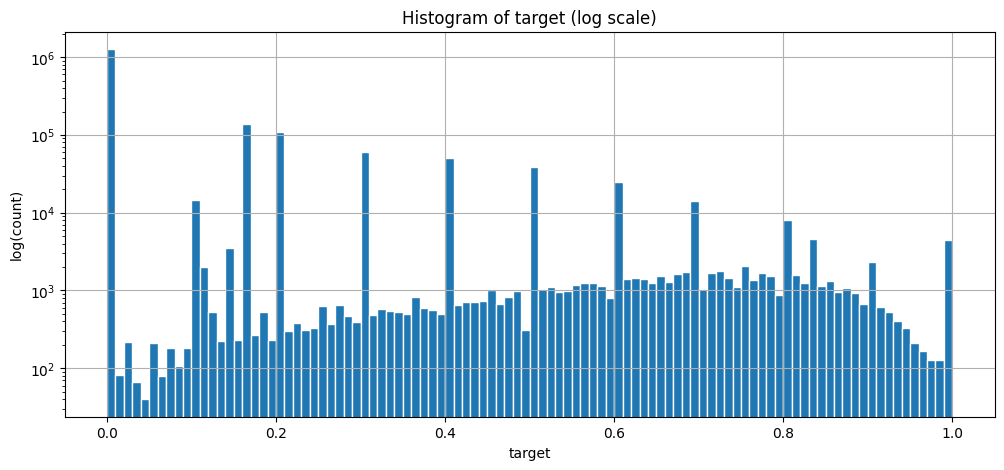

In [9]:
plt.figure(figsize=(12, 5))
df_raw['target'].hist(bins=100, edgecolor='white')
plt.yscale('log')
plt.xlabel('target')
plt.ylabel('log(count)')
plt.title('Histogram of target (log scale)')
plt.show()

In [10]:
thresholds = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
print(f"\nBinary Classification Analysis (% positive class):")
for threshold in thresholds:
    positive_rate = (df_raw['target'] >= threshold).mean()
    print(f"  Threshold >= {threshold:.1f}: {positive_rate:.3f} ({positive_rate:.1%})")

# Threshold for binary classification / stratification
target_balance = 0.1  # Aim for ~10% positive class
optimal_threshold = df_raw['target'].quantile(1 - target_balance)
print(f"For ~{target_balance:.0%} positive class, use threshold >= {optimal_threshold:.3f}")


Binary Classification Analysis (% positive class):
  Threshold >= 0.1: 0.298 (29.8%)
  Threshold >= 0.2: 0.209 (20.9%)
  Threshold >= 0.3: 0.147 (14.7%)
  Threshold >= 0.4: 0.112 (11.2%)
  Threshold >= 0.5: 0.080 (8.0%)
  Threshold >= 0.6: 0.053 (5.3%)
  Threshold >= 0.7: 0.033 (3.3%)
  Threshold >= 0.8: 0.017 (1.7%)
  Threshold >= 0.9: 0.005 (0.5%)
For ~10% positive class, use threshold >= 0.400


### Check for missing values

In [11]:
df_raw.isna().sum()

id                                           0
target                                       0
comment_text                                 3
severe_toxicity                              0
obscene                                      0
identity_attack                              0
insult                                       0
threat                                       0
asian                                  1399744
atheist                                1399744
bisexual                               1399744
black                                  1399744
buddhist                               1399744
christian                              1399744
female                                 1399744
heterosexual                           1399744
hindu                                  1399744
homosexual_gay_or_lesbian              1399744
intellectual_or_learning_disability    1399744
jewish                                 1399744
latino                                 1399744
male         

In [12]:
# Preview NaNs in 'comment_text' (these will need to be removed)
df_raw[df_raw['comment_text'].isna()]

,id,target,comment_text,severe_toxicity,obscene,identity_attack,insult,threat,asian,atheist,...,article_id,rating,funny,wow,sad,likes,disagree,sexual_explicit,identity_annotator_count,toxicity_annotator_count
513346,872115,0.0,NaN,0.0,0.0,0.0,0.0,0.0,NaN,NaN,...,163140,approved,5,0,0,9,1,0.0,0,4
1010795,5353666,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,340316,approved,0,0,0,0,0,0.0,4,4
1512317,5971919,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,378393,approved,0,0,0,1,0,0.0,4,4


### Date distribution over time

The earliest date:  2015-09-29 10:50:41.987077
The latest date:  2017-11-11 01:01:10.822969


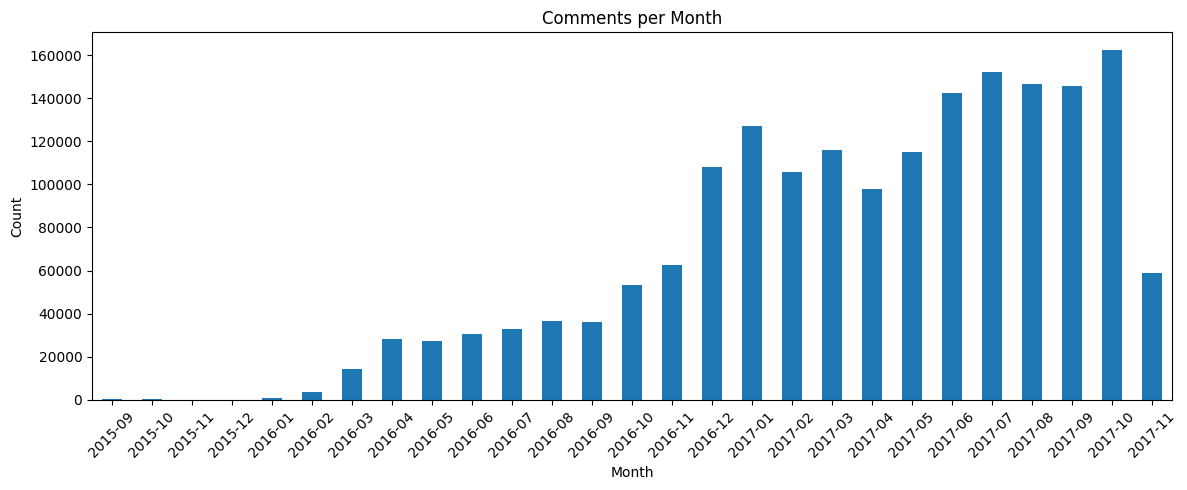

In [13]:
df_raw['created_date'] = pd.to_datetime(df_raw['created_date'], errors='coerce').dt.tz_localize(None)
df_raw['month'] = df_raw['created_date'].dt.to_period('M')

print('The earliest date: ', df_raw['created_date'].min())
print('The latest date: ', df_raw['created_date'].max())

monthly_counts = df_raw['month'].value_counts().sort_index()
months_str = monthly_counts.index.strftime('%Y-%m')

monthly_counts.plot(kind='bar')
plt.xlabel('Month')
plt.ylabel('Count')
plt.title('Comments per Month')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

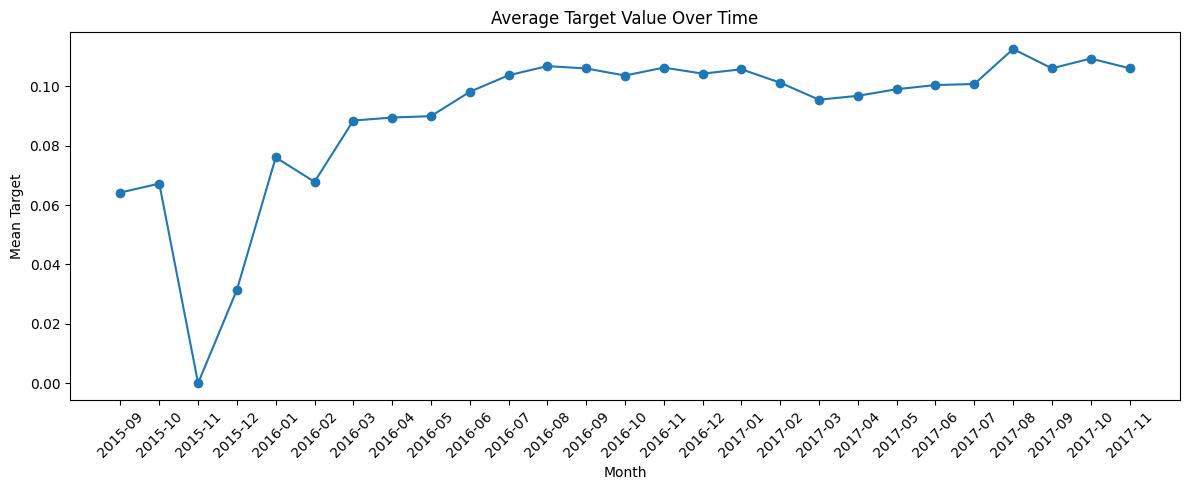

In [14]:
monthly_means = df_raw.groupby('month')['target'].mean()
monthly_means.index = monthly_means.index.astype(str)

plt.plot(monthly_means.index, monthly_means.values, marker='o')
plt.title('Average Target Value Over Time')
plt.ylabel('Mean Target')
plt.xlabel('Month')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

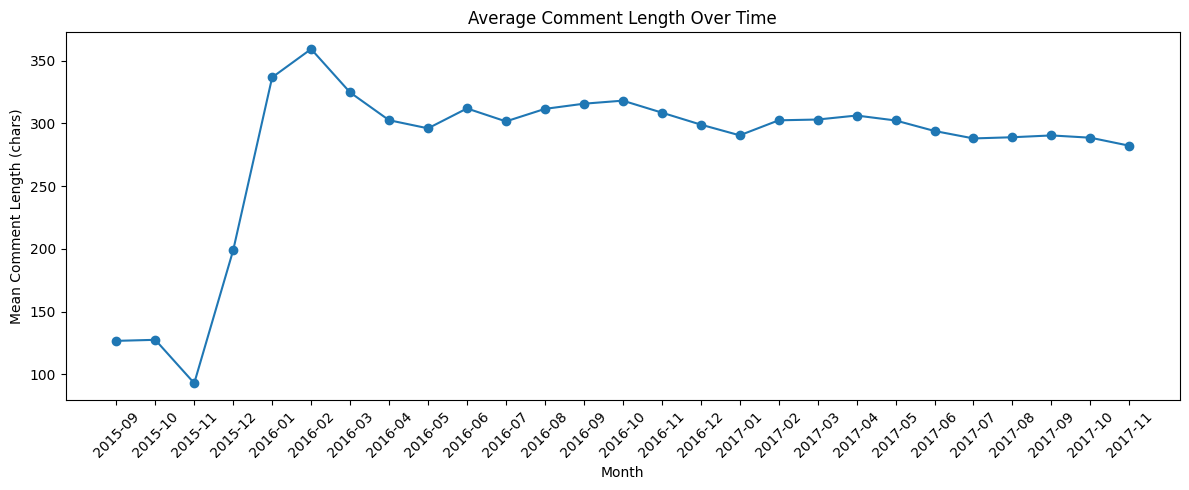

In [15]:
df_raw['month'] = df_raw['created_date'].dt.to_period('M')

monthly_avg_len = df_raw.assign(length=df_raw['comment_text'].str.len()).groupby('month')['length'].mean()
monthly_avg_len.index = monthly_avg_len.index.astype(str)

plt.plot(monthly_avg_len.index, monthly_avg_len.values, marker='o')
plt.title('Average Comment Length Over Time')
plt.ylabel('Mean Comment Length (chars)')
plt.xlabel('Month')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Processed Data Analysis

In [16]:
# Load processed dataset
df_processed = pd.read_csv('../data/processed/train.csv') 

### Basic data info

In [17]:
print(f"Raw dataset: {df_processed.shape[0]:,} rows")
print(f"Processed dataset: {df_processed.shape[0]:,} rows")

print(f"Dataset shape: {df_processed.shape[0]:,} rows x {df_processed.shape[1]} columns")
print(f"Memory usage: {df_processed.memory_usage(deep=True).sum() / 1024**2:.1f} MB")

print(f"\nColumns: {list(df_processed.columns)}")

print(f"\nFirst 5 rows:")
df_processed.head()

Raw dataset: 797,334 rows
Processed dataset: 797,334 rows
Dataset shape: 797,334 rows x 9 columns
Memory usage: 396.7 MB

Columns: ['id', 'comment_text', 'created_date', 'target', 'obscene', 'identity_attack', 'insult', 'threat', 'sexual_explicit']

First 5 rows:


,id,comment_text,created_date,target,obscene,identity_attack,insult,threat,sexual_explicit
0,438908,"That was probably counting all the ushers , fo...",2016-08-19 21:06:04.720450,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
1,589530,FYI: the proper medical term for a miscarriag...,2016-11-10 15:01:03.686547,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
2,5106276,"""Power outages leave more than 30,000 in the d...",2017-04-07 16:49:10.292512,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
3,5245417,Wynn can't be blamed on most of Hydro's messes...,2017-05-11 22:36:54.597580,0.166667,0.000000,0.000000,0.166667,0.000000,0.0
4,5214906,"""I don't like having people coming here who ar...",2017-05-04 17:06:12.824818,0.686567,0.089552,0.044776,0.641791,0.134328,0.0


In [18]:
df_processed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 797334 entries, 0 to 797333
Data columns (total 9 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   id               797334 non-null  int64  
 1   comment_text     797334 non-null  object 
 2   created_date     797334 non-null  object 
 3   target           797334 non-null  float64
 4   obscene          797334 non-null  float64
 5   identity_attack  797334 non-null  float64
 6   insult           797334 non-null  float64
 7   threat           797334 non-null  float64
 8   sexual_explicit  797334 non-null  float64
dtypes: float64(6), int64(1), object(2)
memory usage: 54.7+ MB


In [19]:
df_processed.describe().style.format('{:.2f}')

,id,target,obscene,identity_attack,insult,threat,sexual_explicit
count,797334.00,797334.00,797334.00,797334.00,797334.00,797334.00,797334.00
mean,2039689.63,0.10,0.01,0.02,0.08,0.01,0.01
std,2077953.00,0.20,0.06,0.08,0.17,0.05,0.05
min,59848.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,548709.50,0.00,0.00,0.00,0.00,0.00,0.00
50%,854351.00,0.00,0.00,0.00,0.00,0.00,0.00
75%,5035897.75,0.17,0.00,0.00,0.00,0.00,0.00
max,5336564.00,1.00,1.00,1.00,1.00,1.00,1.00


### Correlation heatmap

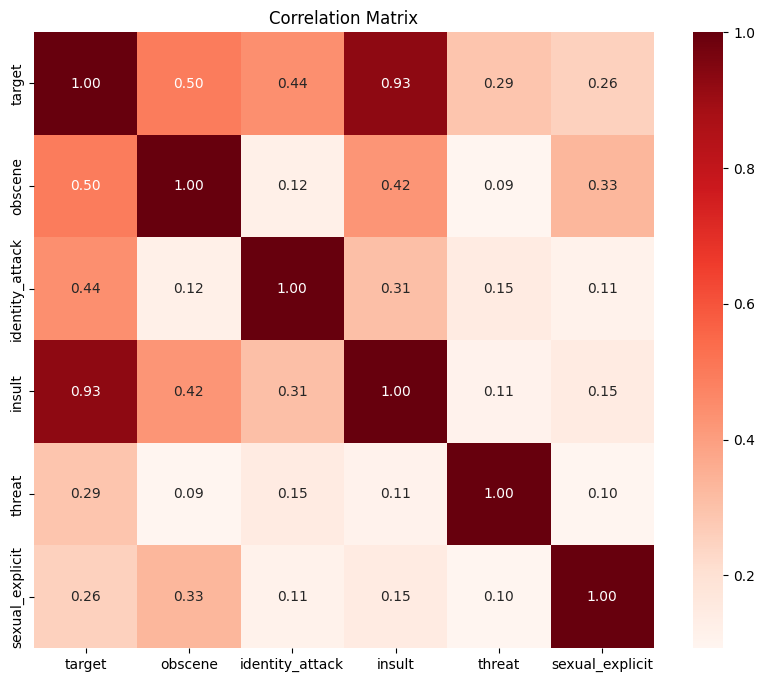

In [20]:
correlation_matrix = df_processed.drop('id', axis=1).corr(numeric_only=True)

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='Reds')
plt.title('Correlation Matrix')
plt.show()

### Target statistics

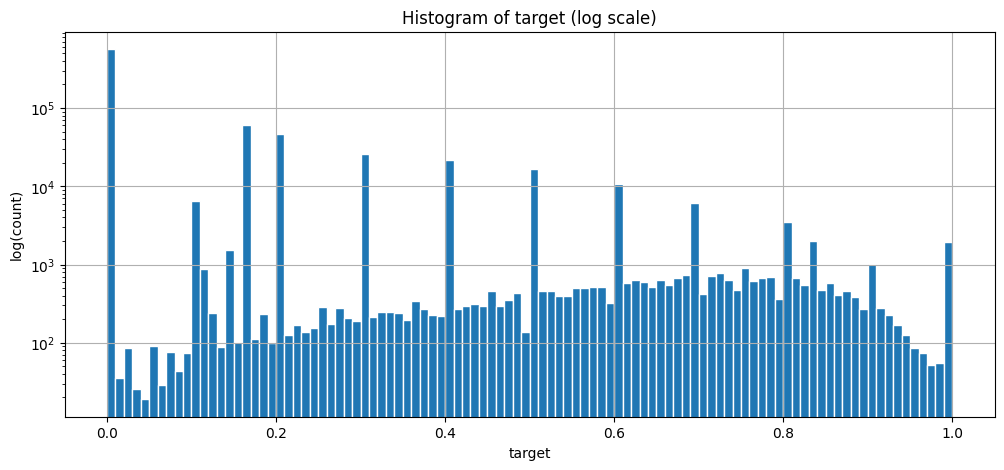

In [21]:
df_processed['target'].hist(bins=100, edgecolor='white')
plt.yscale('log')
plt.xlabel('target')
plt.ylabel('log(count)')
plt.title('Histogram of target (log scale)')
plt.show()

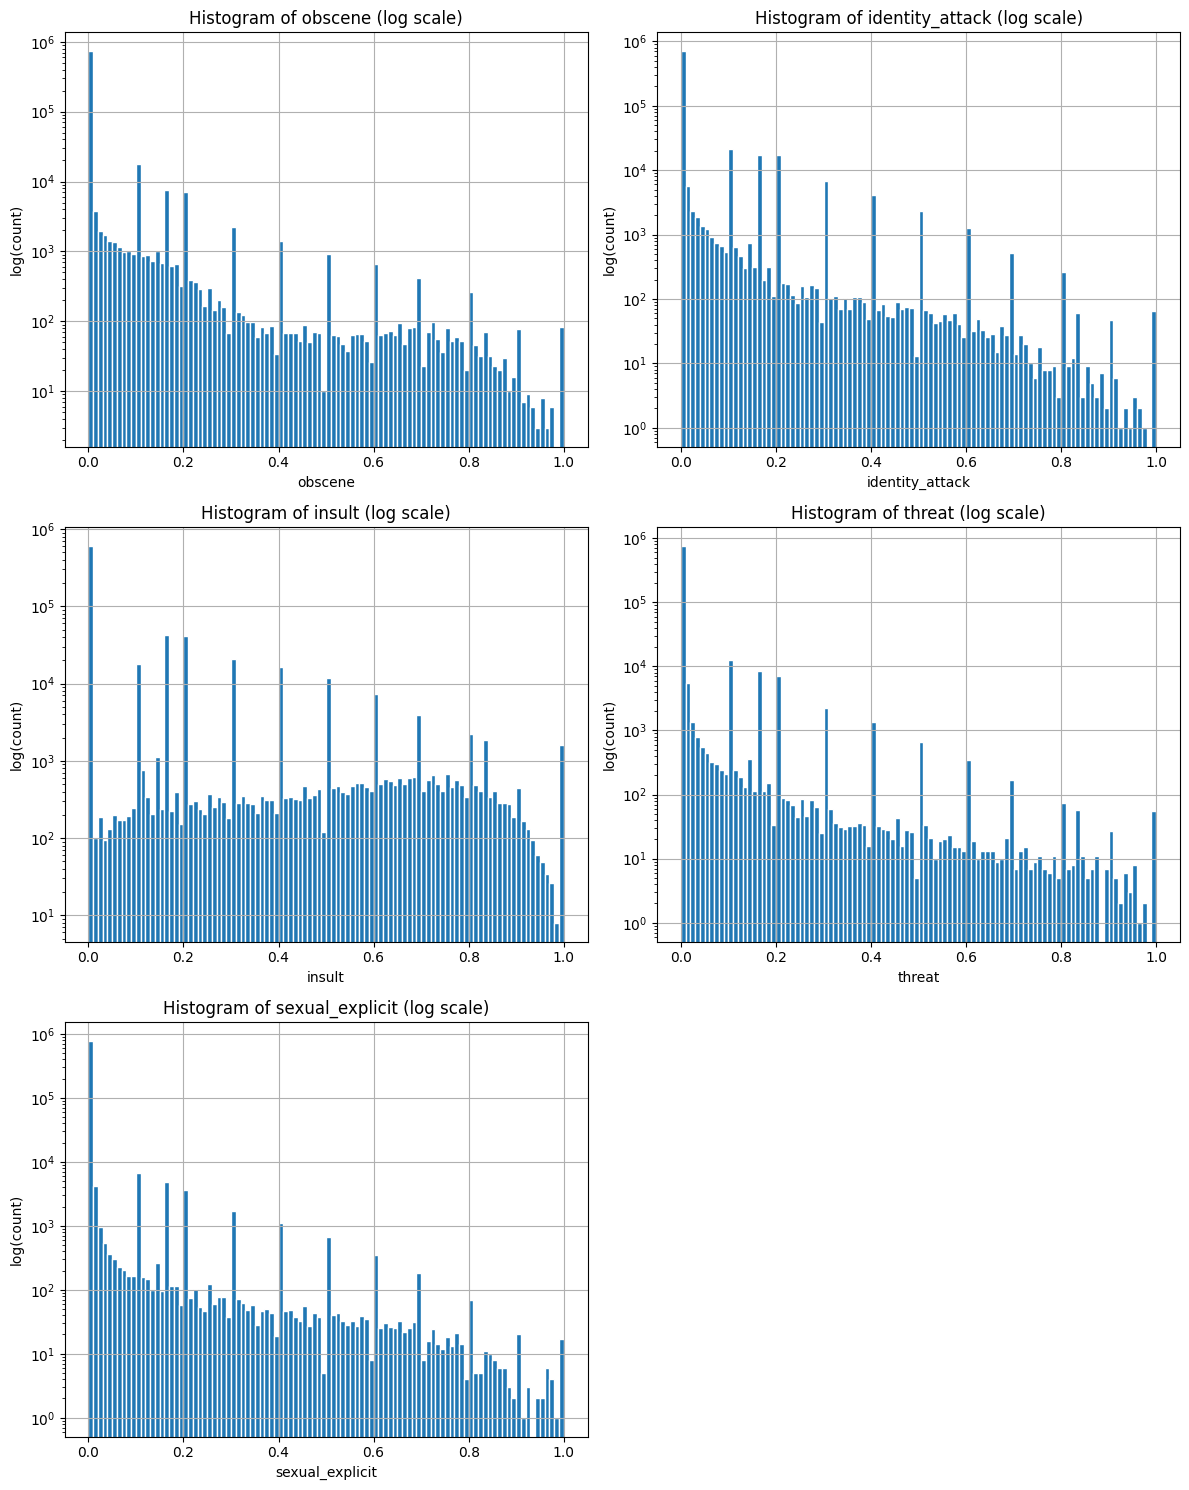

In [23]:
# Histograms for multiple columns with log scale
target_columns = ['obscene', 'identity_attack', 'insult', 'threat', 'sexual_explicit']

plt.figure(figsize=(12, 15))

for i, col in enumerate(target_columns, 1):
    plt.subplot(3, 2, i)
    df_processed[col].hist(bins=100, edgecolor='white')
    plt.yscale('log')
    plt.xlabel(col)
    plt.ylabel('log(count)')
    plt.title(f'Histogram of {col} (log scale)')

plt.tight_layout()
plt.show()

### Text statistics

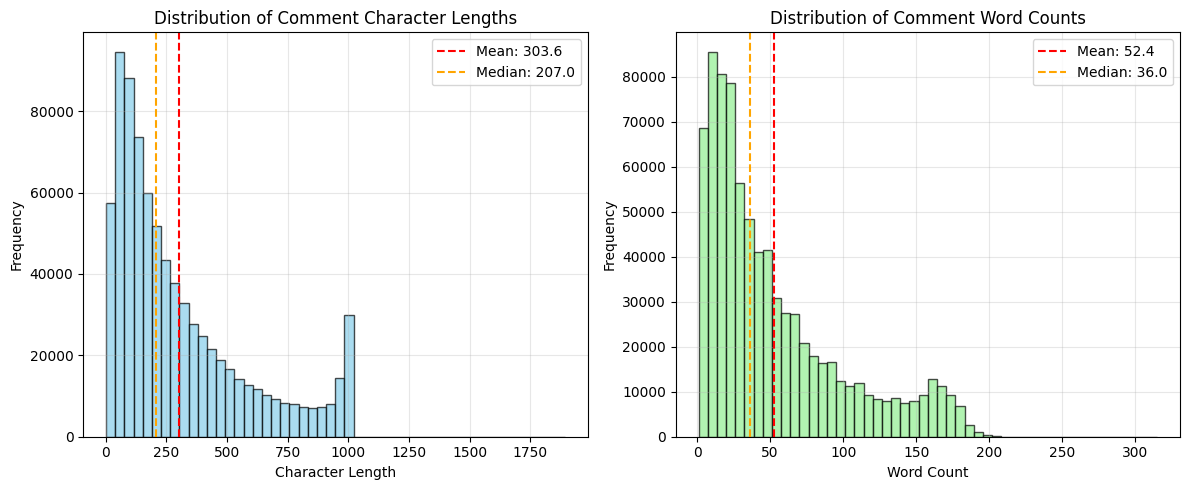

In [24]:
# Character length distribution
texts = df_processed['comment_text'].dropna()
text_lengths = texts.str.len()
word_counts = texts.str.split().str.len()

# Character length distribution
plt.subplot(1, 2, 1)
plt.hist(text_lengths, bins=50, alpha=0.7, color='skyblue', edgecolor='black')
plt.axvline(text_lengths.mean(), color='red', linestyle='--', label=f'Mean: {text_lengths.mean():.1f}')
plt.axvline(text_lengths.median(), color='orange', linestyle='--', label=f'Median: {text_lengths.median():.1f}')
plt.xlabel('Character Length')
plt.ylabel('Frequency')
plt.title('Distribution of Comment Character Lengths')
plt.legend()
plt.grid(True, alpha=0.3)

# Word count distribution
plt.subplot(1, 2, 2)
plt.hist(word_counts, bins=50, alpha=0.7, color='lightgreen', edgecolor='black')
plt.axvline(word_counts.mean(), color='red', linestyle='--', label=f'Mean: {word_counts.mean():.1f}')
plt.axvline(word_counts.median(), color='orange', linestyle='--', label=f'Median: {word_counts.median():.1f}')
plt.xlabel('Word Count')
plt.ylabel('Frequency')
plt.title('Distribution of Comment Word Counts')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

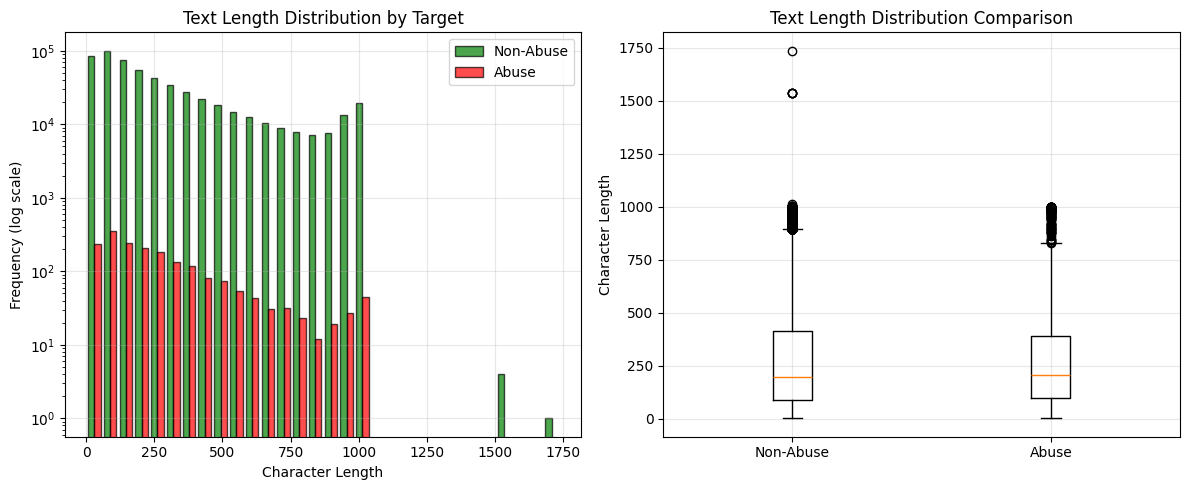

In [25]:
# Text Length Distribution by Target
abuse_mask = df_processed['target'] == 1
non_abuse_mask = df_processed['target'] == 0

abuse_lengths = df_processed.loc[abuse_mask, 'comment_text'].str.len()
non_abuse_lengths = df_processed.loc[non_abuse_mask, 'comment_text'].str.len()

# Histogram for text lengths by target with logarithmic scale
plt.subplot(1, 2, 1)
plt.hist([non_abuse_lengths, abuse_lengths], bins=30, alpha=0.7, 
         label=['Non-Abuse', 'Abuse'], color=['green', 'red'], edgecolor='black', log=True)
plt.xlabel('Character Length')
plt.ylabel('Frequency (log scale)')
plt.title('Text Length Distribution by Target')
plt.legend()
plt.grid(True, alpha=0.3)

# Box plot comparison
plt.subplot(1, 2, 2)
plt.boxplot([non_abuse_lengths.dropna(), abuse_lengths.dropna()], tick_labels=['Non-Abuse', 'Abuse'])
plt.ylabel('Character Length')
plt.title('Text Length Distribution Comparison')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### Sample highly toxic examples

In [26]:
df_processed[df_processed['target'] == 1.0].sample(5)

,id,comment_text,created_date,target,obscene,identity_attack,insult,threat,sexual_explicit
114857,5283555,This is what happens with a neurotic governor ...,2017-05-21 04:29:15.997790,1.0,0.000000,0.0,1.0,0.0,0.0
208592,1077448,"Wow and I mean, ""WOW""!... Who are conservative...",2017-03-04 18:17:00.269033,1.0,0.166667,0.0,1.0,0.0,0.0
383286,627392,your remark makes no sense. we cannot rescue a...,2016-11-26 06:22:44.648672,1.0,0.000000,0.0,1.0,0.0,0.0
668416,5328136,"You portray yourself as a centrist, mediator a...",2017-05-30 18:18:23.063055,1.0,0.000000,0.0,1.0,0.0,0.0
388594,308515,"I bought a solar powered flashlight,darn thing...",2016-05-09 05:36:37.248959,1.0,1.000000,0.0,0.2,0.0,0.0


### Keyword correlation analysis

In [28]:
# Convert comments into bag-of-words with the 1000 most frequent words
vec = CountVectorizer(stop_words='english', max_features=1000)
X = vec.fit_transform(df_processed['comment_text'])

# Extract the most toxic and least toxic comments
X_toxic = X[(df_processed['target'] >= 0.7).values]
X_non_toxic = X[(df_processed['target'] < 0.1).values]

# Calculate mean word frequency
toxic_corr = np.array(X_toxic.mean(axis=0)).flatten()
non_toxic_corr = np.array(X_non_toxic.mean(axis=0)).flatten()

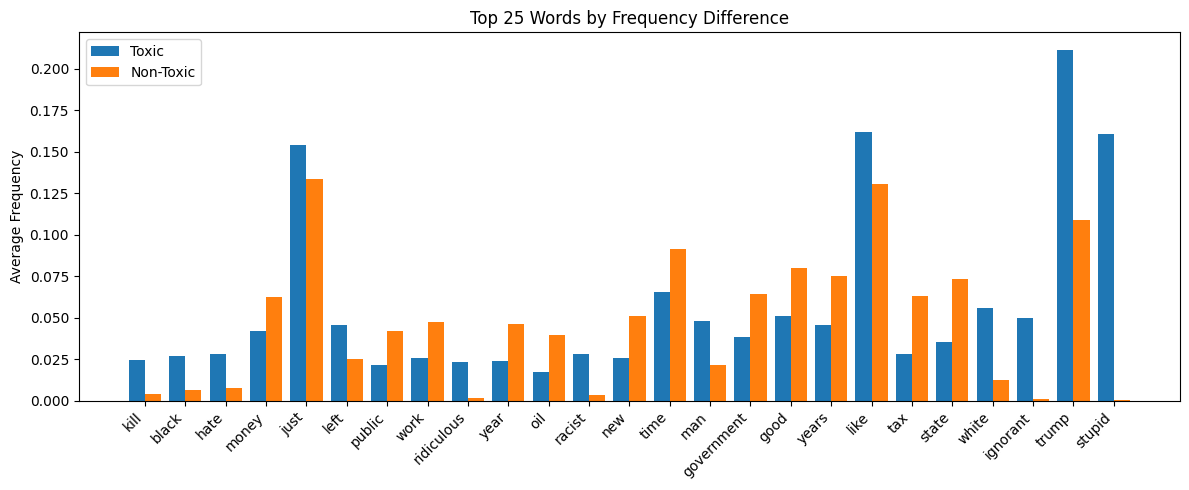

In [29]:
# Compute frequency difference per word
words = vec.get_feature_names_out()
diff = toxic_corr - non_toxic_corr

# Select top 25 words with the largest absolute frequency difference
top_indices = np.argsort(np.abs(diff))[-25:]

plt.figure(figsize=(12, 5))
x = np.arange(len(top_indices))
plt.bar(x - 0.2, toxic_corr[top_indices], width=0.4, label='Toxic')
plt.bar(x + 0.2, non_toxic_corr[top_indices], width=0.4, label='Non-Toxic')
plt.xticks(x, words[top_indices], rotation=45, ha='right')
plt.ylabel('Average Frequency')
plt.title(f'Top 25 Words by Frequency Difference')
plt.legend()
plt.tight_layout()
plt.show()

## Label Binarization

We convert continuous annotation proportions (fraction of annotators marking toxicity) into binary indicators using a fixed threshold of 0.5 (majority agreement). This provides a simplified target for baseline classification and evaluation.

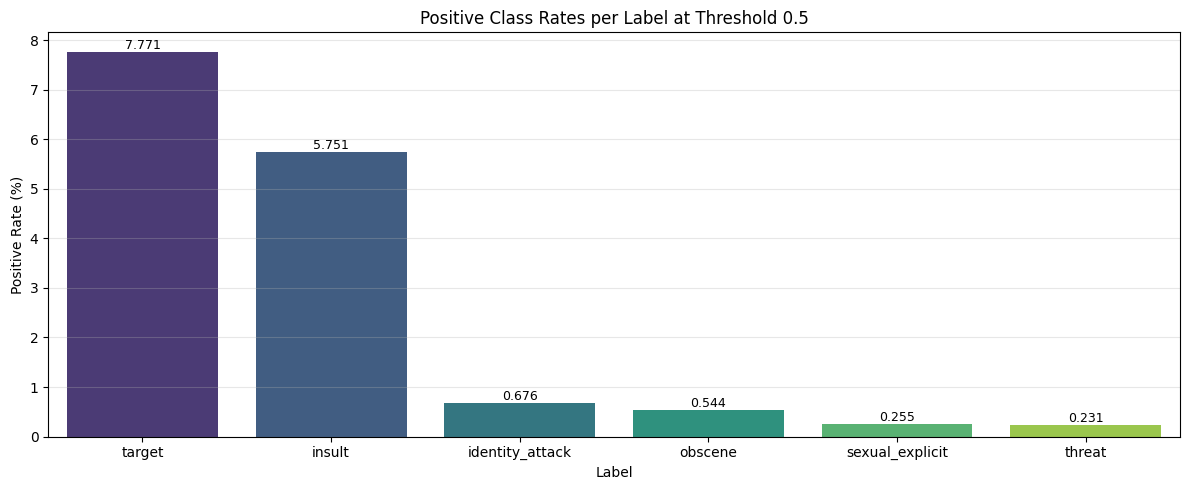

,label,positives,total,positive_rate
0,target,61958,797334,7.770646
3,insult,45853,797334,5.750790
2,identity_attack,5391,797334,0.676128
1,obscene,4337,797334,0.543938
5,sexual_explicit,2032,797334,0.254849
4,threat,1845,797334,0.231396


In [30]:
# Compute positive class ratios for each toxicity-related label at threshold 0.5
labels = ['target', 'severe_toxicity', 'obscene', 'identity_attack', 'insult', 'threat', 'sexual_explicit']
threshold = 0.5

binarized_stats = []
for col in labels:
    if col in df_processed.columns:
        positives = (df_processed[col] >= threshold).sum()
        total = df_processed[col].notna().sum()
        ratio = positives / total if total else 0
        binarized_stats.append({
            'label': col,
            'positives': int(positives),
            'total': int(total),
            'positive_rate': ratio * 100
        })

binarized_df = pd.DataFrame(binarized_stats).sort_values('positive_rate', ascending=False)

# Bar plot of positive rates
sns.barplot(data=binarized_df, x='label', y='positive_rate', palette='viridis')
plt.ylabel('Positive Rate (%)')
plt.xlabel('Label')
plt.title('Positive Class Rates per Label at Threshold 0.5')
plt.grid(axis='y', alpha=0.3)
for i, row in enumerate(binarized_df.itertuples()):
    plt.text(i, row.positive_rate + 0.0005, f"{row.positive_rate:.3f}", ha='center', va='bottom', fontsize=9)
plt.tight_layout()
plt.show()

binarized_df

In [31]:
labels = ['target', 'obscene', 'identity_attack', 'insult', 'threat', 'sexual_explicit']

bins = np.arange(0, 1.0001, 0.1)
for col in labels:
    print(f"\nLabel: {col}")
    binned = pd.cut(df_processed[col], bins=bins, right=True, include_lowest=False)  # (a,b]
    counts = binned.value_counts().sort_index()
    perc = counts / counts.sum()
    summary = pd.DataFrame({
        'count': counts,
        'percent': perc * 100
    })
    print(summary)

    print("Example (first occurrence) per non-empty bin:")
    for interval, cnt in counts.items():
        if cnt == 0:
            continue
        left = interval.left
        right = interval.right
        mask = (df_processed[col] > left) & (df_processed[col] <= right)
        idxs = df_processed.index[mask]
        if len(idxs) == 0:
            continue
        row = df_processed.loc[idxs[0]]
        text = row['comment_text'].replace('\n', '\\n')
        print(f" {interval}: value={row[col]:.3f} | {text}")


Label: target
             count    percent
target                       
(0.0, 0.1]    6988   2.981305
(0.1, 0.2]  111114  47.404797
(0.2, 0.3]   27402  11.690572
(0.3, 0.4]   23863  10.180721
(0.4, 0.5]   19444   8.295434
(0.5, 0.6]   14610   6.233095
(0.6, 0.7]   11442   4.881524
(0.7, 0.8]    9335   3.982610
(0.8, 0.9]    6943   2.962107
(0.9, 1.0]    3253   1.387834
Example (first occurrence) per non-empty bin:
 (0.0, 0.1]: value=0.100 | JJ:  I know....Sometimes I just can't contain myself.  My Mom told me "don't feed the trolls or poke the hornet's nest."  I'm getting old and forgetful and, unfortunately, can't outrun those hornets anymore.  regards, Gary
 (0.1, 0.2]: value=0.167 | Wynn can't be blamed on most of Hydro's messes (they goes back to the Davis Conservatives in the 70s and have been continued by every single government since).  But with this move she's gone from bribing voters with their own money (the rebate scam) to bribing voters with our children's money, which i

### After binarization

In [32]:
# Load binarized dataset
df_binarized = pd.read_csv('../data/binarized/train.csv') 

In [33]:
df_binarized.head()

,id,comment_text,created_date,target,obscene,identity_attack,insult,threat,sexual_explicit
0,438908,"That was probably counting all the ushers , fo...",2016-08-19 21:06:04.720450,0,0,0,0,0,0
1,589530,FYI: the proper medical term for a miscarriag...,2016-11-10 15:01:03.686547,0,0,0,0,0,0
2,5106276,"""Power outages leave more than 30,000 in the d...",2017-04-07 16:49:10.292512,0,0,0,0,0,0
3,5245417,Wynn can't be blamed on most of Hydro's messes...,2017-05-11 22:36:54.597580,0,0,0,0,0,0
4,5214906,"""I don't like having people coming here who ar...",2017-05-04 17:06:12.824818,1,0,0,1,0,0


In [ ]:
df_binarized.describe().style.format('{:.2f}')

,id,target,obscene,identity_attack,insult,threat,sexual_explicit
count,797334.00,797334.00,797334.00,797334.00,797334.00,797334.00,797334.00
mean,2039689.63,0.08,0.01,0.01,0.06,0.00,0.00
std,2077953.00,0.27,0.07,0.08,0.23,0.05,0.05
min,59848.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,548709.50,0.00,0.00,0.00,0.00,0.00,0.00
50%,854351.00,0.00,0.00,0.00,0.00,0.00,0.00
75%,5035897.75,0.00,0.00,0.00,0.00,0.00,0.00
max,5336564.00,1.00,1.00,1.00,1.00,1.00,1.00


: 